In [1]:
import gc   # For manual garbage collection.
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from utils import traceplots
from inference_toolbox import Parameter, Model, Likelihood, Sampler
from GPM_analysis import GPM_analysis

experiment = 'Exp1'

# Import and select data.
all_data = pd.read_csv('total_data.csv',
    usecols = ['gps.lat', 'gps.lon', 'altitudeRelative', 'Concentration', 'Experiment','Transect','Peak_Dist'],
)
all_data = all_data[all_data['Experiment'] == experiment]
all_data = all_data.drop(columns = ['Experiment'])

# Import and select metadata.
experiment_metadata = pd.read_csv('data_summary.csv',
    usecols = ['Experiment', 'Wind_Dir', 'WindSpeed', 'boat.lat', 'boat.lon']
)
experiment_metadata = experiment_metadata[experiment_metadata['Experiment'] == experiment]
wind_dir = experiment_metadata['Wind_Dir'].values[0]
wind_speed = experiment_metadata['WindSpeed'].values[0]

# Converting lat and lon to distances from boat in downwind and crosswind directions.
all_data['dist_lat'] = (all_data['gps.lat'] - experiment_metadata['boat.lat'].values[0]) * 111000
all_data['dist_lon'] = (all_data['gps.lon'] - experiment_metadata['boat.lon'].values[0]) * 111000
all_data['x'] = all_data['dist_lon'] * np.cos(270 - wind_dir) + all_data['dist_lat'] * np.sin(270 - wind_dir)
all_data['y'] = all_data['dist_lon'] * np.cos(360 - wind_dir) + all_data['dist_lat'] * np.sin(360 - wind_dir)
all_data['z'] = all_data['altitudeRelative']
all_data['T'] = all_data['Transect']
all_data['PD'] = all_data['Peak_Dist']

all_data['Concentration'] = all_data['Concentration']*100**3

# Split data, 80% for training and 20% for testing, shuffling rows first.
all_data = all_data.drop(columns = ['altitudeRelative', 'dist_lat', 'dist_lon', 'gps.lat', 'gps.lon','Transect','Peak_Dist'])
all_data = np.asarray(all_data)   # Prepare for Numba.
np.random.seed(1)                 # Ensure the same split each time.
np.random.shuffle(all_data)
training_data, testing_data = np.split(all_data, [int(0.8 * len(all_data))])

# Release unused memory.
del(experiment)
del(experiment_metadata)
del(wind_dir)
gc.collect()

0

In [2]:
# Initialize parameter series
params = pd.Series({},dtype='float64')

# Parameter Assignment
a = Parameter(init_val = 0.33, step_select = "positive gaussian", step_size = 0.01, prior_select = "gaussian")
a.add_prior_param("mu",0.33)
a.add_prior_param("sigma",0.01)
params['a'] = a

b = Parameter(init_val = 0.87, step_select = "positive gaussian", step_size = 0.01, prior_select = "gaussian")
b.add_prior_param("mu",0.87)
b.add_prior_param("sigma",0.01)
params['b'] = b

Q = Parameter(init_val = 3e13, step_select = "positive gaussian", step_size = 1e12, prior_select = "gaussian")
Q.add_prior_param("mu",3e13)
Q.add_prior_param("sigma",1e12)
params['Q'] = Q

# Model Assignment
model = Model()
model.add_model_param("H",10)
model.add_model_param("u",wind_speed)
model_func = model.get_model('GPM')

# Likelihood function assigmnent
likelihood = Likelihood()
likelihood.add_likelihood_param("sigma",1e11)
# likelihood.add_likelihood_param("lambda_1",1)
# likelihood.add_likelihood_param("lambda_2",0.05)
likelihood_func = likelihood.get_log_likelihood_func("gaussian fixed sigma")

# Initialize and run sampler
sampler = Sampler(params, model_func, likelihood_func, training_data)
params_samples = sampler.sample_all(10000)

# Get mean values from samples
params_mean = sampler.get_mean_samples(params_samples)

Running sample 1000...
Running sample 2000...
Running sample 3000...
Running sample 4000...
Running sample 5000...
Running sample 6000...
Running sample 7000...
Running sample 8000...
Running sample 9000...
Running sample 10000...


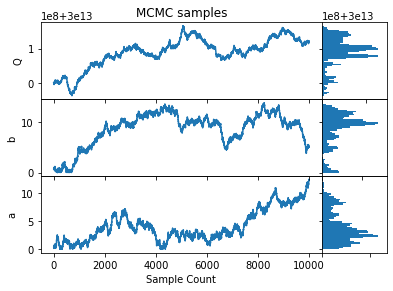

In [6]:
# Format samples and construct traceplots
params_samples_formatted = params_samples.copy()
for col in params_samples_formatted:
    params_samples_formatted[col] = params_samples_formatted[col].apply(lambda x: x.val)
traceplots(np.array(params_samples_formatted), xnames = params_samples_formatted.columns, title = 'MCMC samples')

RMSE = 916730083.9885267
Range = 10483296070.256554
Distance from peak value: 10688828088.8102


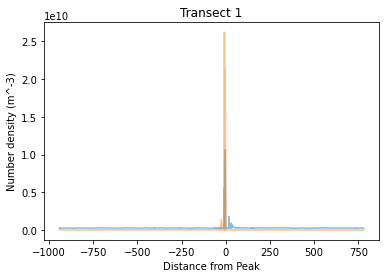

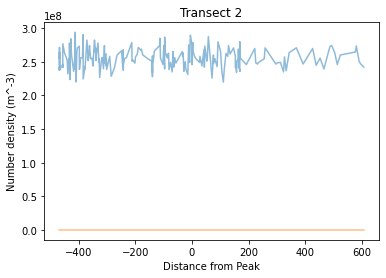

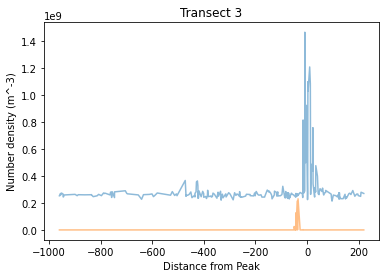

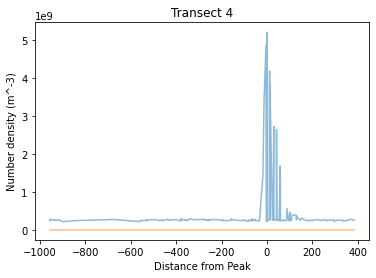

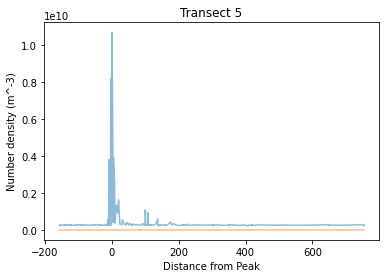

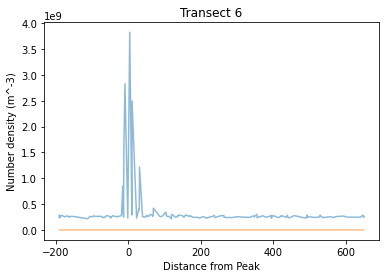

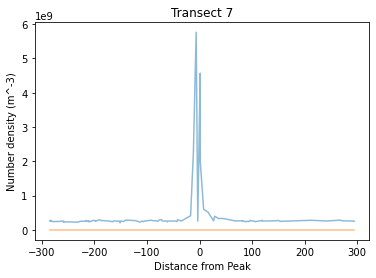

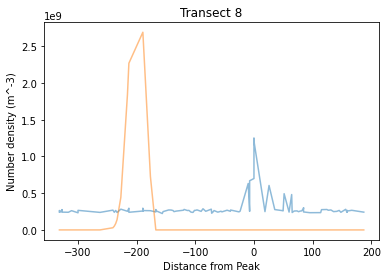

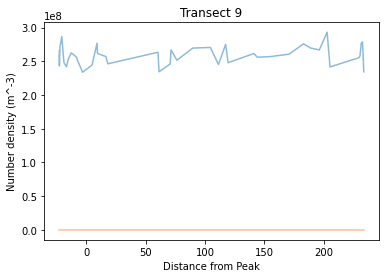

In [4]:
# Analyse the predictions
test_predictions = model_func(params,testing_data[:,1],testing_data[:,2],testing_data[:,3])
GPM_analyser = GPM_analysis(test_predictions, testing_data)
RMSE = GPM_analyser.RMSE_func()
pdist = GPM_analyser.peak_distance()
GPM_analyser.compare_transects()

C:\Users\samue\AppData\Local\Temp/ipykernel_18292/2056482742.py:26: RuntimeWarning: divide by zero encountered in log
  plt.pcolor(X, Y, np.log(C), shading = 'auto')


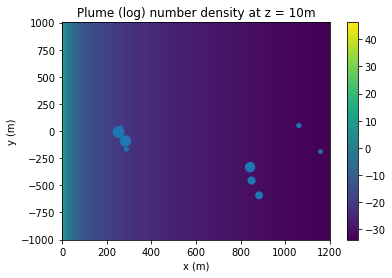

a =  4.101605972761711
b =  8.592817808190787
Q =  30000089097932.98


In [5]:
# Plotting slices of the plume at set Z values using the mean values of the parameters.

x = np.linspace(0.1, 1200, 501)
y = np.linspace(-1000, 1000, 501)
X,Y = np.meshgrid(x, y)
Z = 10

del(x)
del(y)

grid = np.zeros((X.shape[0]**2,3))
grid[:,0] = X.reshape(X.shape[0]**2)
grid[:,1] = Y.reshape(Y.shape[0]**2)
grid[:,2] = np.ones(X.shape[0]**2)*Z

unique_transects = np.unique(all_data[:,4])
maximums = []
for transect in unique_transects:
    transect_data = all_data[all_data[:,4]==transect]
    max_ind = np.argmax(transect_data[:,0])
    maximums.append([transect_data[max_ind,1],transect_data[max_ind,2],transect_data[max_ind,3],transect_data[max_ind,0]])
maximums = np.array(maximums)

C = model_func(params_mean, X,Y,Z)

plt.pcolor(X, Y, np.log(C), shading = 'auto')
plt.colorbar()
plt.scatter(maximums[:,0], maximums[:,1], s=maximums[:,3]/1e8)
plt.title('Plume (log) number density at z = ' + str(Z)+'m')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

print('a = ',params_mean.a.val)
print('b = ',params_mean.b.val)
print('Q = ',params_mean.Q.val)